# 用于验证回测框架的独立程序 (V7 - 信号对冲与仓位净额结算模型)

**目的**: 解决V6版本中因独立交易模型导致的潜在手续费重复计算问题。本版本引入一个更真实的、基于仓位净额结算的回测模型。

**核心逻辑**:
1.  **引入全新的 `run_netting_backtest` 函数**：该函数将取代旧的重叠交易模型。
2.  **维护一个动态的“在管仓位池”**: 程序会实时追踪所有活跃的、尚未平仓的交易。
3.  **信号的双重作用机制**:
    - **对冲优先**: 当一个新的交易信号 (`signal_new`) 出现时，程序会首先在仓位池中寻找是否存在方向相反 (`-signal_new`) 的、最早开立的持仓。
    - **如果找到相反持仓**: 新信号将被用于“对冲”掉这个旧持仓。这对交易被视为一个组合，根据您的要求，它们各自只支付开仓时的手续费，不再支付平仓手续费。旧持仓被平仓，新信号被消耗。
    - **如果未找到相反持仓**: 新信号将按常规逻辑开立一笔新的交易，并设定一个固定的到期时间（例如，10个周期后）。
4.  **精确的成本核算**:
    - **常规到期平仓**: 交易从开仓到期满平仓，计算两次手续费（一开一平）。
    - **对冲提前平仓**: 互相抵消的一对交易，总共只计算两次开仓手续费，无平仓费用，显著降低了交易成本。
5.  **单利计算**: 严格遵循单利模式，所有交易的盈亏都基于初始资本进行计算，然后进行累加。

In [11]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style
import pickle
from pathlib import Path
from collections import deque

---
## 1. 日志和绘图设置

In [12]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数 (源于旧代码)

In [13]:
def run_netting_backtest(prices, signals, initial_capital, commission_rate, holding_period):
    """
    执行一个基于信号对冲和仓位净额结算的回测。
    新信号优先用于对冲已有的反向仓位。
    使用单利模型。

    返回:
    - pd.DataFrame: 包含回测结果的DataFrame。
    - pd.Series: 包含每笔已完成交易的净收益率的序列。
    """
    logging.info(f"🤔🤔开始执行仓位对冲回测 (持仓周期: {holding_period} bars)...")

    # --- 数据结构初始化 ---
    # 使用双端队列高效处理“最早”的交易
    active_trades = deque()
    completed_trades_pnl = [] # 存储每笔完成交易的 {exit_time, pnl_rate}
    
    # 用于记录每个时间点的仓位和已实现盈亏
    positions_over_time = pd.Series(0, index=prices.index)
    realized_pnl_stream = pd.Series(0.0, index=prices.index)

    # --- 时间驱动的事件循环 ---
    # prices.index 是 Timestamp 对象，可以直接比较
    for current_time in prices.index:
        
        # --- 1. 处理到期平仓 ---
        # 检查是否有交易在当前时间点到期
        # 使用 while 循环处理在同一时间点有多个交易到期的情况
        while active_trades and active_trades[0]['exit_time'] == current_time:
            trade_to_close = active_trades.popleft() # 从队列头部取出最早的交易
            
            entry_price = prices.at[trade_to_close['entry_time']]
            exit_price = prices.at[current_time]
            
            # 计算毛收益率
            gross_pnl_rate = trade_to_close['direction'] * (exit_price / entry_price - 1)
            # 常规到期，计算两次手续费
            net_pnl_rate = gross_pnl_rate - (2 * commission_rate)
            
            # 记录这笔已完成的交易
            completed_trades_pnl.append({'exit_time': current_time, 'pnl_rate': net_pnl_rate})
            # 在平仓日实现该笔收益
            realized_pnl_stream.at[current_time] += net_pnl_rate

    
        # --- 2. 处理新信号 ---
        # 信号产生于 T-1 时刻，在 T 时刻 (current_time) 执行操作
        # 我们需要找到 T-1 时刻的索引位置
        try:
            prev_time_loc = prices.index.get_loc(current_time) - 1
            if prev_time_loc < 0:
                # 这是第一个bar，没有 T-1
                positions_over_time.at[current_time] = sum(t['direction'] for t in active_trades)
                continue
            prev_time = prices.index[prev_time_loc]
            signal = signals.at[prev_time]
        except (KeyError, IndexError):
            # 如果当天没有信号或索引越界，则跳过
            positions_over_time.at[current_time] = sum(t['direction'] for t in active_trades)
            continue

        if signal != 0:
            # --- 2a. 尝试对冲 ---
            opposite_trade_found = False
            # 遍历寻找可以对冲的相反仓位
            for i, trade in enumerate(active_trades):
                if trade['direction'] == -signal:
                    trade_to_net = active_trades[i]
                    # 从队列中移除该交易
                    del active_trades[i]
                    
                    entry_price = prices.at[trade_to_net['entry_time']]
                    exit_price = prices.at[current_time] # 在当前时间点对冲平仓
                    
                    # 计算毛收益率
                    gross_pnl_rate = trade_to_net['direction'] * (exit_price / entry_price - 1)
                    # **核心逻辑**: 根据要求，对冲交易只计算开仓费，不计算平仓费
                    # 因为新信号也被认为消耗了一次开仓机会，所以总成本是两次开仓费
                    net_pnl_rate = gross_pnl_rate - (2 * commission_rate)
                    
                    completed_trades_pnl.append({'exit_time': current_time, 'pnl_rate': net_pnl_rate})
                    realized_pnl_stream.at[current_time] += net_pnl_rate
                    
                    opposite_trade_found = True
                    break # 对冲完成，跳出循环

            # --- 2b. 如果没有可对冲的仓位，则开新仓 ---
            if not opposite_trade_found:
                # 计算预期的退出时间
                try:
                    current_time_loc = prices.index.get_loc(current_time)
                    exit_time_loc = current_time_loc + holding_period
                    if exit_time_loc < len(prices.index):
                        exit_time = prices.index[exit_time_loc]
                        
                        new_trade = {
                            'entry_time': current_time,
                            'direction': signal,
                            'exit_time': exit_time
                        }
                        active_trades.append(new_trade)
                except (KeyError, IndexError):
                    # 如果无法确定退出时间（例如，接近数据末尾），则不开仓
                    pass

        # --- 3. 更新当前总仓位 ---
        positions_over_time.at[current_time] = sum(t['direction'] for t in active_trades)

    logging.info(f"共完成 {len(completed_trades_pnl)} 笔交易的结算。")

    # --- 4. 计算权益曲线 ---
    pnl_in_dollars = realized_pnl_stream * initial_capital
    cumulative_pnl = pnl_in_dollars.cumsum()
    equity_curve = initial_capital + cumulative_pnl

    # --- 5. 结果整合 ---
    backtest_results = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'position': positions_over_time,
        'market_returns': prices.pct_change().fillna(0),
        'strategy_net_returns': realized_pnl_stream,
        'equity_curve': equity_curve
    })
    
    # 将已完成交易的pnl列表转换为Series，用于评估函数
    if completed_trades_pnl:
        trade_list_df = pd.DataFrame(completed_trades_pnl)
        trade_list_series = pd.Series(trade_list_df['pnl_rate'].values, index=trade_list_df['exit_time'])
    else:
        trade_list_series = pd.Series([])

    logging.info("🎉🎉仓位对冲回测完成。")
    return backtest_results, trade_list_series

In [14]:
def evaluate_performance(backtest_results, trade_list_series, evaluation_criteria, initial_capital):
    """
    评估策略表现的函数 (与V6版本基本一致，适配单利和新的回测输出)。
    """
    logging.info("🤔🤔🤔开始评估策略表现 (仓位对冲模型)...")

    equity_curve = backtest_results['equity_curve']
    net_returns = backtest_results['strategy_net_returns'] # 这是每日实现的收益率流
    market_returns = backtest_results['market_returns']
    positions = backtest_results['position']
    
    # 直接使用回测函数生成的已完成交易列表
    trade_returns_series = trade_list_series

    # --- 核心指标计算 (单利模型) ---
    annualization_factor = 12 # 基于月度数据年化
    total_days = (equity_curve.index[-1] - equity_curve.index[0]).days if len(equity_curve) > 1 else 0
    duration_years = total_days / 365.0 if total_days > 0 else 1 

    # 总收益率 (单利)
    total_return = (equity_curve.iloc[-1] / initial_capital) - 1 if initial_capital != 0 else 0
    # 年化收益率 (单利)
    annualized_return = total_return / duration_years if duration_years > 0 else 0

    # 基于实现的日度盈亏流来计算月度收益
    monthly_net_returns = net_returns.resample('M').sum().dropna()
    monthly_market_returns = (1 + market_returns).resample('M').prod() - 1 # 基准仍为复利

    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        annualized_volatility = monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        annualized_volatility = 0

    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = abs(drawdown.min())
    end_date_idx = drawdown.idxmin() if not drawdown.empty else None
    peak_idx = equity_curve.loc[:end_date_idx].idxmax() if end_date_idx is not None else None
    max_drawdown_start_date = peak_idx
    max_drawdown_end_date = end_date_idx

    # 夏普比率 (单利)
    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        sharpe_ratio = monthly_net_returns.mean() / monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        sharpe_ratio = 0

    # 卡玛比率 (单利)
    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else 0

    # --- 交易统计 ---
    winning_trades_pnl = trade_returns_series[trade_returns_series > 0]
    losing_trades_pnl = trade_returns_series[trade_returns_series <= 0]
    total_trades = len(trade_returns_series)
    num_winning_trades = len(winning_trades_pnl)
    num_losing_trades = len(losing_trades_pnl)
    win_rate = num_winning_trades / total_trades if total_trades > 0 else 0
    total_profit_amount_trades = winning_trades_pnl.sum()
    total_loss_amount_trades = abs(losing_trades_pnl.sum())
    profit_loss_ratio = total_profit_amount_trades / total_loss_amount_trades if total_loss_amount_trades > 0 else np.inf
    expectancy = (win_rate * profit_loss_ratio) - (1 - win_rate) if win_rate > 0 and profit_loss_ratio != np.inf else -1
    
    num_open_trades = total_trades
    total_weeks = len(pd.date_range(start=equity_curve.index[0], end=equity_curve.index[-1], freq=Week())) if len(equity_curve) > 1 else 0
    weekly_trade_frequency = num_open_trades / total_weeks if total_weeks > 0 else 0

    # 索提诺比率 (单利)
    downside_monthly_returns = monthly_net_returns[monthly_net_returns < 0]
    if not downside_monthly_returns.empty and downside_monthly_returns.std() != 0:
        downside_std = downside_monthly_returns.std()
        sortino_ratio = monthly_net_returns.mean() / downside_std * np.sqrt(annualization_factor)
    else:
        sortino_ratio = 0
        
    average_win = winning_trades_pnl.mean() if num_winning_trades > 0 else 0
    average_loss = abs(losing_trades_pnl.mean()) if num_losing_trades > 0 else 0
    total_pnl_amount = equity_curve.iloc[-1] - initial_capital

    annual_returns = net_returns.resample('Y').sum()
    annual_returns.index = annual_returns.index.year

    # --- 打印报告 (此处代码与之前版本类似，为简洁省略重复的打印逻辑) ---
    print("\n" + "="*80)
    print(Fore.CYAN + " " * 20 + "策略性能评估报告 (仓位对冲模型)" + " " * 20 + Style.RESET_ALL)
    print("="*80)
    
    def format_check(name, value, req_value, req_prefix, comp_func):
        status = "✅ 达标" if comp_func(value, req_value) else "❌ 未达标"
        req_str = f"{req_prefix} {req_value}"
        color = Fore.GREEN if comp_func(value, req_value) else Fore.RED
        return [name, f"{value:.4f}", req_str, color + status + Style.RESET_ALL]

    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " 收益指标 " + "="*30 + Style.RESET_ALL)
    sharpe_req, calmar_req, expectancy_req = evaluation_criteria['sharpe_ratio'], evaluation_criteria['calmar_ratio'], evaluation_criteria['expectancy']
    sharpe_ok, calmar_ok, expectancy_ok = sharpe_ratio > sharpe_req, calmar_ratio > calmar_req, expectancy > expectancy_req
    profit_plan1_ok, profit_plan2_ok, profit_ok = sharpe_ok and calmar_ok, expectancy_ok, (sharpe_ok and calmar_ok) or expectancy_ok
    headers = ["指标名称", "计算结果", "要求", "状态"]
    profit_table = [
        format_check("夏普比率 (Sharpe)", sharpe_ratio, sharpe_req, ">", lambda v, r: v > r),
        format_check("卡玛比率 (Calmar)", calmar_ratio, calmar_req, ">", lambda v, r: v > r),
        format_check("期望收益 (Expectancy)", expectancy, expectancy_req, ">", lambda v, r: v > r)
    ]
    print(tabulate(profit_table, headers=headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " 风控与效率指标 " + "="*30 + Style.RESET_ALL)
    mdd_req, freq_req = evaluation_criteria['max_drawdown'], evaluation_criteria['weekly_frequency']
    mdd_ok, freq_ok = max_drawdown < mdd_req, weekly_trade_frequency > freq_req
    risk_table = [
        format_check("最大回撤 (MDD)", max_drawdown, mdd_req, "<", lambda v, r: v < r),
        format_check("每周开仓频率", weekly_trade_frequency, freq_req, ">", lambda v, r: v > r)
    ]
    print(tabulate(risk_table, headers=headers, tablefmt="grid", stralign="center", numalign="center"))

    print("\n" + Fore.GREEN + Style.BRIGHT + "="*30 + " 详细指标 " + "="*30 + Style.RESET_ALL)
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["总收益率 (Total Return)", f"{total_return:.4f}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.4f}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.4f}"],
        ["索提诺比率 (Sortino Ratio)", f"{sortino_ratio:.4f}"],
        ["总盈亏 (Total PnL)", f"{total_pnl_amount:,.2f}"],
        ["总交易笔数 (Total Trades)", f"{total_trades}"],
        ["胜率 (Win Rate)", f"{win_rate:.4f}"],
        ["盈亏比 (Profit Factor)", f"{profit_loss_ratio:.4f}"],
        ["平均盈利 (Avg Win PNL %)", f"{average_win:.4%}"],
        ["平均亏损 (Avg Loss PNL %)", f"{average_loss:.4%}"],
        ["最大回撤起始日期", str(max_drawdown_start_date)],
        ["最大回撤结束日期", str(max_drawdown_end_date)]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))

    # --- 绘制权益曲线图 ---
    benchmark_equity = initial_capital * (1 + market_returns).cumprod()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    
    equity_curve.plot(label='Strategy Equity (Netting Model)', lw=2, color='royalblue', ax=ax1)
    benchmark_equity.plot(label='Buy & Hold Benchmark', lw=2, linestyle='--', color='darkorange', ax=ax1)
    ax1.set_title('Strategy vs. Benchmark Equity (Netting Model)', fontsize=16)
    ax1.set_ylabel('Equity', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    positions.plot(label='Total Position (Net)', lw=1.5, color='purple', ax=ax2, drawstyle='steps-post')
    ax2.set_title('Net Position Size', fontsize=14)
    ax2.set_ylabel('Net Number of Positions', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    logging.info("🎊🎊🎊策略评估完成🎊🎊🎊")

---
## 3. 主程序执行

2025-07-24 13:02:45,708 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-24 13:02:45,715 - INFO - 数据加载成功，索引已转换为DatetimeIndex。
2025-07-24 13:02:45,715 - INFO - 🤔🤔开始执行仓位对冲回测 (持仓周期: 10 bars)...
2025-07-24 13:02:53,736 - INFO - 共完成 25522 笔交易的结算。
2025-07-24 13:02:53,755 - INFO - 🎉🎉仓位对冲回测完成。
2025-07-24 13:02:53,757 - INFO - 🤔🤔🤔开始评估策略表现 (仓位对冲模型)...



                    策略性能评估报告 (仓位对冲模型)                    

============================== 收益指标 ==============================
+-----------------------+------------+--------+-----------+
|       指标名称        |  计算结果  |  要求  |   状态    |
+=======================+============+========+===========+
|   夏普比率 (Sharpe)   |   -0.891   | > 1.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
|   卡玛比率 (Calmar)   |  -0.2166   | > 2.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
| 期望收益 (Expectancy) |  -0.0812   | > 0.1  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+

============================== 风控与效率指标 ==============================
+----------------+------------+--------+-----------+
|    指标名称    |  计算结果  |  要求  |   状态    |
+================+============+========+===========+
| 最大回撤 (MDD) |   6.6595   | < 0.25 | ❌ 未达标 |
+----------------+------------+--------+-----------+
|  每周开仓频率  |  129.553   |  > 5   |  ✅ 达标  |
+--------

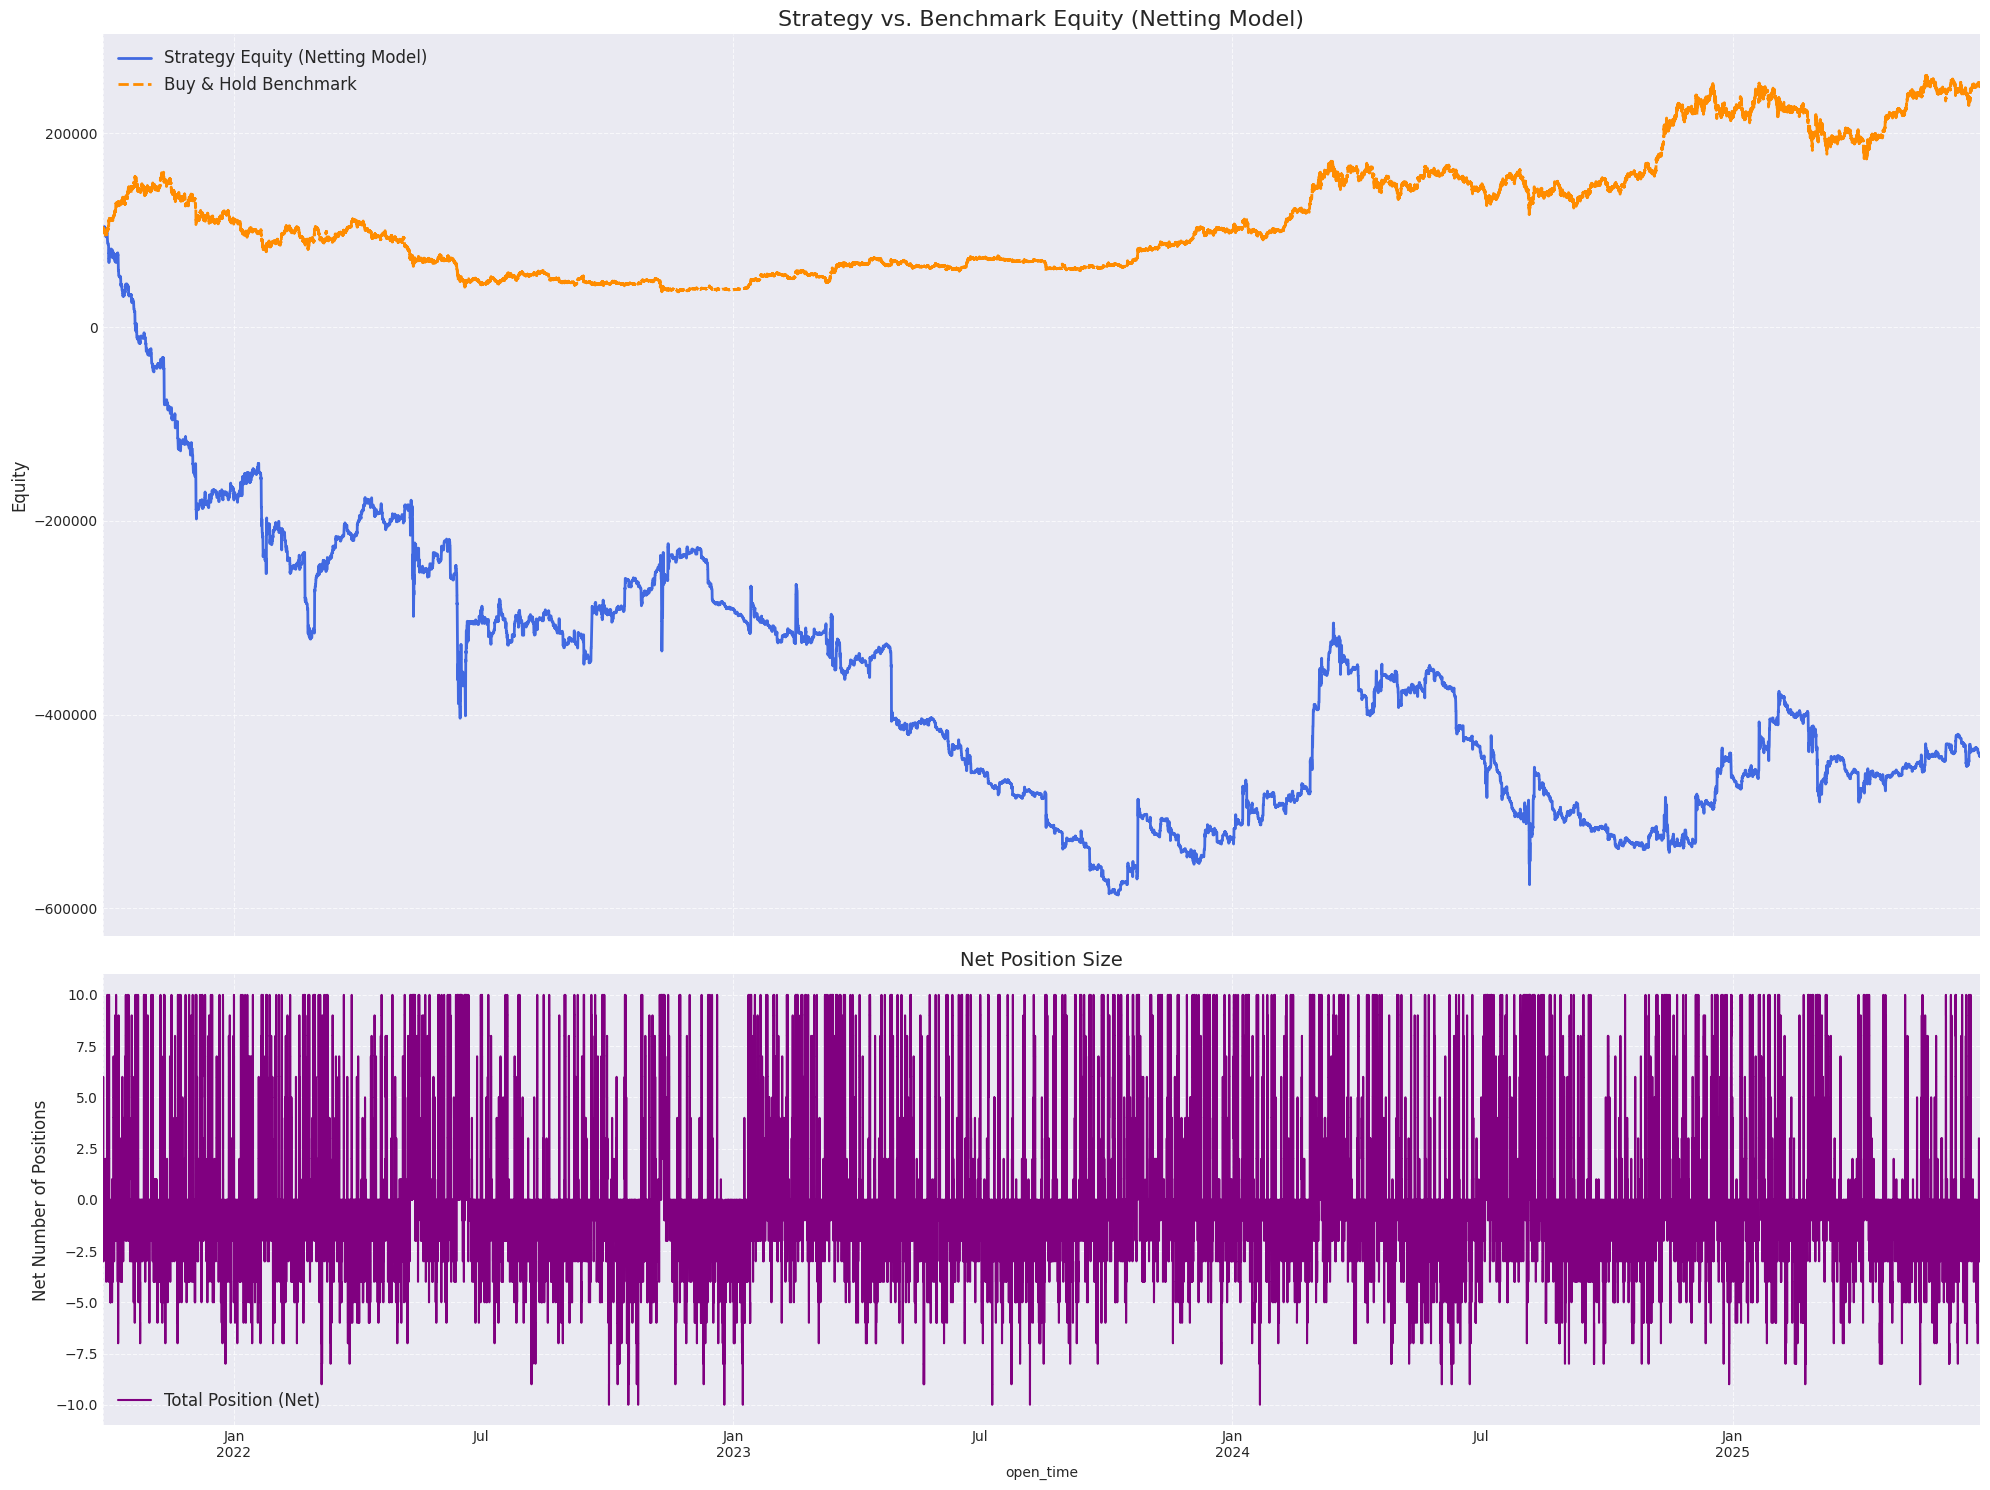

2025-07-24 13:02:59,188 - INFO - 🎊🎊🎊策略评估完成🎊🎊🎊


In [15]:
if __name__ == '__main__':
    # --- 参数配置 ---
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    COMMISSION_RATE = 0.0002
    INITIAL_CAPITAL = 100000
    HOLDING_PERIOD = 10 # 信号发出后，持仓10个15分钟bar
    
    EVALUATION_CRITERIA = {
        'sharpe_ratio': 1.0,      # 调整为更合理的单利目标
        'calmar_ratio': 2.0,      # 调整为更合理的单利目标
        'expectancy': 0.10,       # 调整为更合理的单利目标
        'max_drawdown': 0.25,     # 25%
        'weekly_frequency': 5
    }

    # --- 步骤 1: 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    try:
        backtest_data = pd.read_pickle(FILE_PATH)
        # 确保索引是 DatetimeIndex
        backtest_data.index = pd.to_datetime(backtest_data.index)
        logging.info("数据加载成功，索引已转换为DatetimeIndex。")
    except Exception as e:
        logging.error(f"数据加载失败: {e}")
        exit()

    # --- 步骤 2: 执行全新的对冲回测 ---
    backtest_results, trade_list_series = run_netting_backtest(
        prices=backtest_data['close'],
        signals=backtest_data['signal'],
        initial_capital=INITIAL_CAPITAL,
        commission_rate=COMMISSION_RATE,
        holding_period=HOLDING_PERIOD
    )

    # --- 步骤 3: 性能评估 ---
    # 检查回测结果是否为空
    if backtest_results is not None and not backtest_results.empty:
        evaluate_performance(
            backtest_results=backtest_results,
            trade_list_series=trade_list_series,
            evaluation_criteria=EVALUATION_CRITERIA,
            initial_capital=INITIAL_CAPITAL
        )
    else:
        logging.warning("回测未能生成有效结果，跳过性能评估。")